# Introduction

The notebook is a demo for usage of two regularization utils: l0_layer, l0_dense. We use very simple 2-layer MLP architecture to build Autoencoders for reconstructing MNIST dataset. L0 is applied here in two cases: 
- Experiment1: regularize on the weights and biases on the the two layers of the AE
- Experiment2: regularize on the latent activation of the AE


L0 regularization [(Louizos et al 2017)](https://arxiv.org/abs/1712.01312) is an approximate regularization being done by creating a surrogate mask which will alter the original architecture of the networks, for details, one can have look at the interactive tensorboard created in both of the experiments

l0_layer, and l0_dense are designed to be easy to deploy:
1- 
2- 

### Todo:
1. weight evaluation for L0LMLP_AE
2. maybe other datasets 

# Preparation

In [1]:
""" Auto Encoder Example.
Kuan: The template is borrowed from some github REPO

Using an auto encoder on MNIST handwritten digits.
References:
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
"""



' Auto Encoder Example.\nUsing an auto encoder on MNIST handwritten digits.\nReferences:\n    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based\n    learning applied to document recognition." Proceedings of the IEEE,\n    86(11):2278-2324, November 1998.\nLinks:\n    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/\n'

In [2]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tb_graph_jupyter import show_graph
# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)


# dense_test = tf.layers.dense
from l0_regularization.l0_dense import l0_dense
from l0_regularization.l0_layer import l0_layer

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_input = 784 # MNIST data input (img shape: 28*28)
reg_const = 1e-6 # ~ 1e3/n == 1e5-1e6 for MNIST

total_batch = int(mnist.train.num_examples/batch_size)

# Neural Nets Modules:

In [4]:
def l0_encoder(x, is_training):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = l0_dense(x, n_hidden_1, 
                       is_training=is_training,
                       activation=tf.nn.relu,
                       kernel_regularization_scale=reg_const,
                       bias_regularization_scale=reg_const)    
    return layer_1

def l0_decoder(x, is_training):
    layer_1 = l0_dense(x, n_input, 
                       is_training=is_training,
                       kernel_regularization_scale=reg_const,
                       bias_regularization_scale=reg_const)
    return layer_1

# Experiment1: L0MLP_AE:

### L0MLP_AE: Build Graph and Graph Visualization (TensorBoard)

In [5]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():    
    X = tf.placeholder("float", [None, n_input])
    is_training = tf.placeholder(tf.bool, [], name='is_training')    
    # Construct model
    with tf.variable_scope('encoder'):
        encoder_op = l0_encoder(X, is_training)    
    
    with tf.variable_scope('decoder'):
        decoder_op = l0_decoder(encoder_op, is_training)

    # Prediction
    y_pred = decoder_op
    # Targets (Labels) are the input data.
    y_true = X

    # Define loss and optimizer, minimize the squared error
    losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    print(losses)
    
    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2)) + tf.reduce_sum(losses)
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()
    # Launch the graph
    # Using InteractiveSession (more convenient while using Notebooks)
    sess = tf.InteractiveSession()
    sess.run(init)
    
tf.summary.FileWriter("logs", g).close()

[<tf.Tensor 'encoder/l0_dense/kernel/Regularizer/l0_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'encoder/l0_dense/bias/Regularizer/l0_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'decoder/l0_dense/kernel/Regularizer/l0_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'decoder/l0_dense/bias/Regularizer/l0_regularizer:0' shape=() dtype=float32>]


In [20]:
show_graph(g)

### L0MLP_AE: Training

In [6]:
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, is_training: True})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(c))

print("Optimization Finished!")

Epoch: 0001 cost= 0.328957438
Epoch: 0002 cost= 0.313364148
Epoch: 0003 cost= 0.305895805
Epoch: 0004 cost= 0.299261838
Epoch: 0005 cost= 0.296064556
Epoch: 0006 cost= 0.291447580
Epoch: 0007 cost= 0.283238262
Epoch: 0008 cost= 0.280321509
Epoch: 0009 cost= 0.272918701
Epoch: 0010 cost= 0.264732659
Optimization Finished!


### L0MLP_AE: Evaluation

/is/sg/klee/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


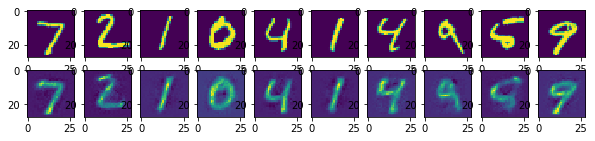

In [7]:
# Applying encode and decode over test set
encode_decode = sess.run(y_pred, feed_dict={X: mnist.test.images[:examples_to_show], is_training: False})
encoded_training = sess.run(encoder_op, 
                            feed_dict={X: mnist.test.images[:examples_to_show], is_training: True})
encoded_pred= sess.run(encoder_op, 
                       feed_dict={X: mnist.test.images[:examples_to_show], is_training: False})
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    
f.show()
plt.show()

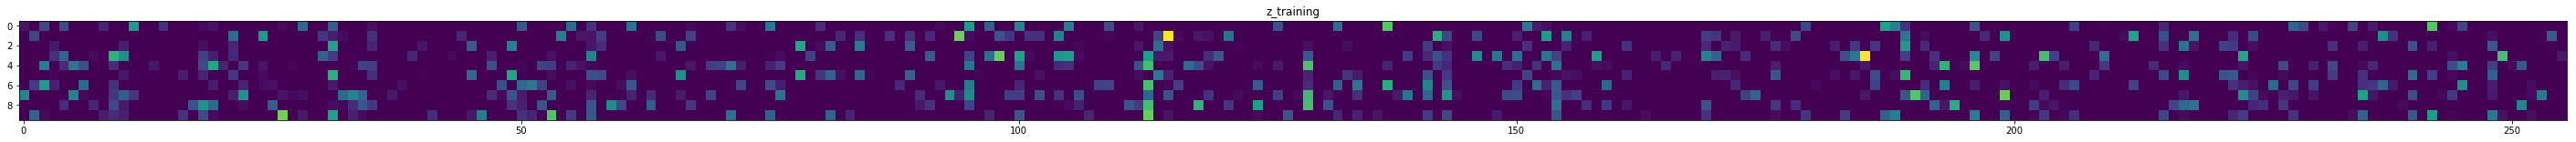

In [8]:
# latents for training
fig2 = plt.figure(figsize=(50, 300))
plt.imshow(encoded_training)
plt.title('z_training')

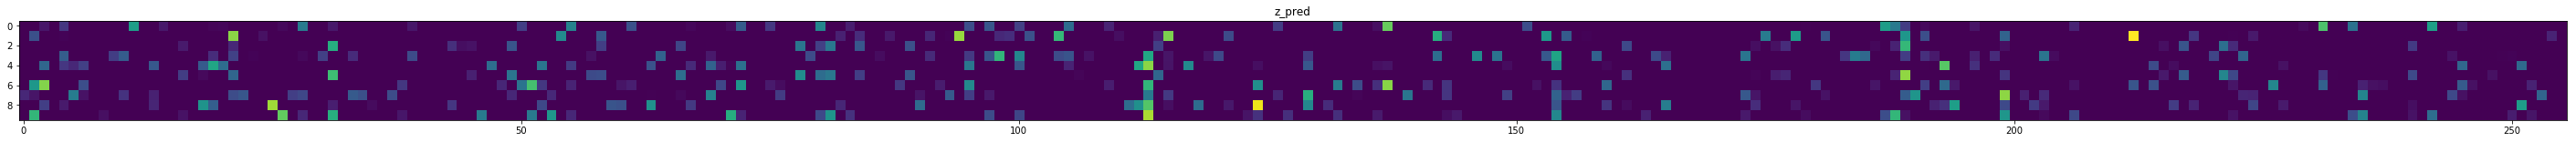

In [9]:
# latents for prediction
fig = plt.figure(figsize=(50, 300))
plt.imshow(encoded_pred)
plt.title('z_pred')

In [10]:
print(encoded_pred-encoded_training)

[[-0.11735778  0.         -0.34254348 ...  0.          0.
   0.        ]
 [ 0.         -0.09592277  0.         ... -0.01740316 -0.45362172
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02301922
   0.        ]
 ...
 [-0.78789026  0.07270996  0.         ... -0.37969553  0.
   0.        ]
 [ 0.          0.          0.2487053  ...  0.          0.
   0.        ]
 [ 0.          0.2345925  -0.05812084 ...  0.          0.
   0.        ]]


# Experiement2: MLPAE with L0 regularized representation (L0L_AE)

### L0L_AE: Build Graph and Graph Visualization (TensorBoard)

In [11]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():    
    X = tf.placeholder("float", [None, n_input])
    is_training = tf.placeholder(tf.bool, [], name='is_training')    
    # Construct model
    with tf.variable_scope('encoder'):
        encoder_op = tf.layers.dense(X, n_hidden_1, activation=tf.nn.relu)    
    encoder_op = l0_layer(encoder_op, reg_const, is_training)
    with tf.variable_scope('decoder'):
        decoder_op = tf.layers.dense(encoder_op, n_input)

    # Prediction
    y_pred = decoder_op
    # Targets (Labels) are the input data.
    y_true = X

    # Define loss and optimizer, minimize the squared error
    losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    print(losses)
    
    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2)) + tf.reduce_sum(losses)
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()
    # Launch the graph
    # Using InteractiveSession (more convenient while using Notebooks)
    sess = tf.InteractiveSession()
    sess.run(init)
    
tf.summary.FileWriter("logs", g).close()

[<tf.Tensor 'l0__layer/l0_regularizer:0' shape=() dtype=float32>]


In [28]:
show_graph(g)

### L0L_AE: Training

In [12]:
training_epochs = 1
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, is_training: True})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(c))

print("Optimization Finished!")

Epoch: 0001 cost= 0.055686753
Optimization Finished!


### L0L_AE: Evaluation

/is/sg/klee/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


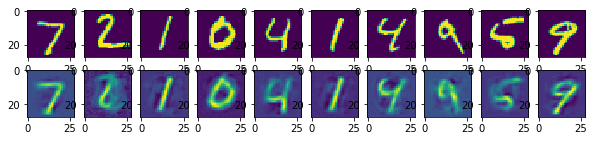

In [43]:
# Applying encode and decode over test set
encode_decode = sess.run(y_pred, feed_dict={X: mnist.test.images[:examples_to_show], is_training: False})
encoded_training = sess.run(encoder_op, 
                            feed_dict={X: mnist.test.images[:examples_to_show], is_training: True})
encoded_pred= sess.run(encoder_op, 
                       feed_dict={X: mnist.test.images[:examples_to_show], is_training: False})
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    
f.show()
plt.show()

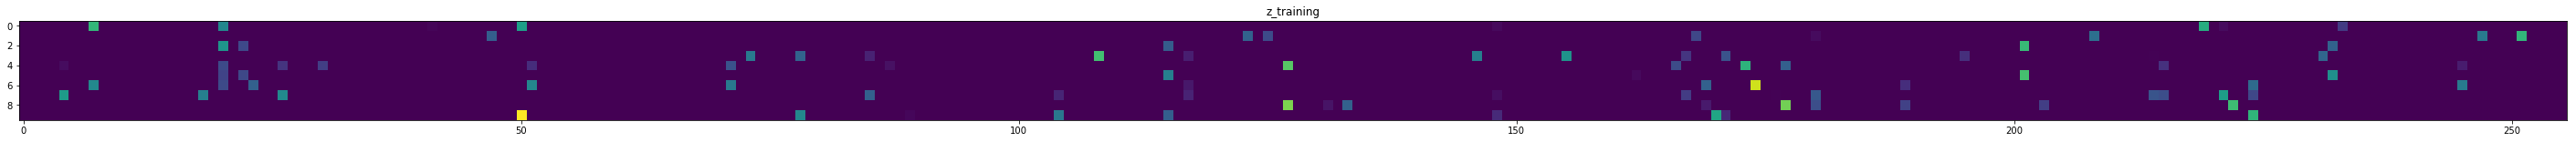

In [44]:
# latents for training
fig2 = plt.figure(figsize=(50, 300))
plt.imshow(encoded_training)
plt.title('z_training')

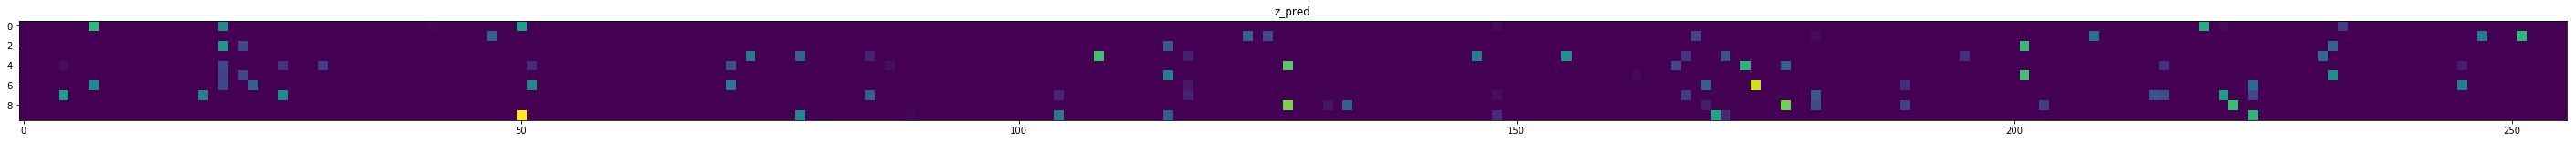

In [45]:
# latents for prediction
fig = plt.figure(figsize=(50, 300))
plt.imshow(encoded_pred)
plt.title('z_pred')

In [46]:
ex = 5
print('original latent space size', n_hidden_1)
print('\t')

zt = encoded_pred[ex, encoded_pred[ex,:]>0]
zp = encoded_training[ex, encoded_training[ex,:]>0]

print("* non-zero encoded_pred of example ex:", zp, "with size: ", len(zp))
print("\t")
print("* non-zero encoded_training of example ex", zt, "with size: ", len(zt))

original latent space size 256
	
* non-zero encoded_pred of example ex: [7.5521803e-01 8.1180048e-01 1.6101726e+00 9.5767528e-02 1.5421808e-03
 2.6440680e+00 1.8621894e+00] with size:  7
	
* non-zero encoded_training of example ex [7.5521803e-01 8.1180048e-01 1.6101726e+00 9.5767528e-02 1.5421808e-03
 2.6440680e+00 1.8621894e+00] with size:  7


In [47]:
# oberservation: when training epoch increase, the gap between the two are disappearing
print(np.sum(encoded_pred - encoded_training))

0.0


### L0L_AE: Eval2: Early Stop

/is/sg/klee/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


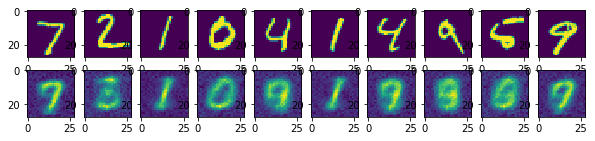

In [13]:
# Applying encode and decode over test set
encode_decode = sess.run(y_pred, feed_dict={X: mnist.test.images[:examples_to_show], is_training: False})
encoded_training = sess.run(encoder_op, 
                            feed_dict={X: mnist.test.images[:examples_to_show], is_training: True})
encoded_pred= sess.run(encoder_op, 
                       feed_dict={X: mnist.test.images[:examples_to_show], is_training: False})
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    
f.show()
plt.show()

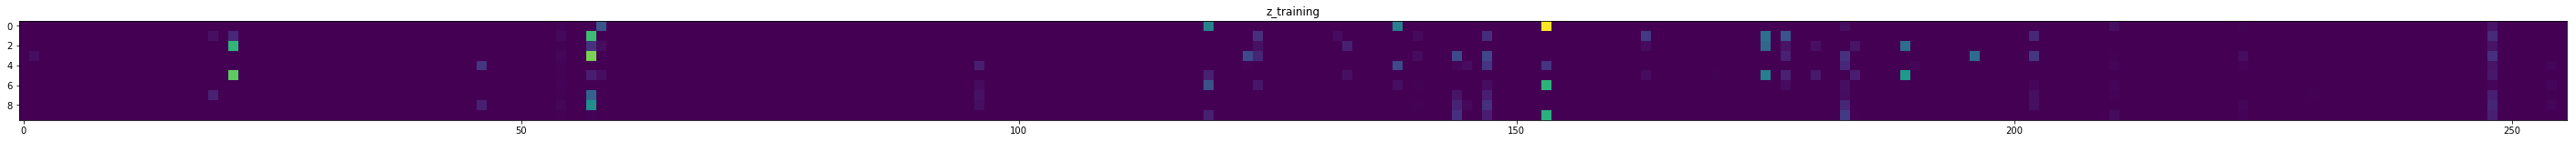

In [14]:
# latents for training
fig2 = plt.figure(figsize=(50, 300))
plt.imshow(encoded_training)
plt.title('z_training')

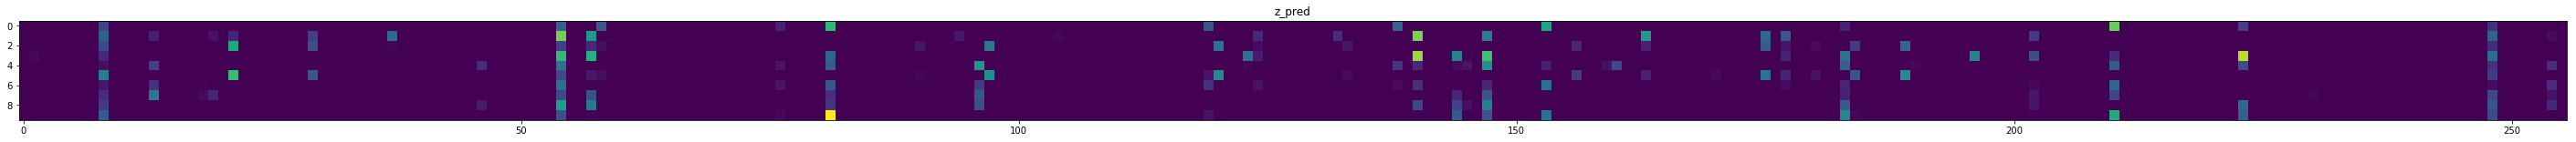

In [15]:
# latents for prediction
fig = plt.figure(figsize=(50, 300))
plt.imshow(encoded_pred)
plt.title('z_pred')

In [16]:
ex = 5
print('original latent space size', n_hidden_1)
print('\t')

zt = encoded_pred[ex, encoded_pred[ex,:]>0]
zp = encoded_training[ex, encoded_training[ex,:]>0]

print("* non-zero encoded_pred of example ex:", zp, "with size: ", len(zp))
print("\t")
print("* non-zero encoded_training of example ex", zt, "with size: ", len(zt))

original latent space size 256
	
* non-zero encoded_pred of example ex: [1.8778119  0.01521494 0.19808786 0.09690923 0.2257895  0.10316844
 0.07250769 0.01728796 1.06393    0.2312871  0.16748829 0.19532454
 1.3415122  0.16353942] with size:  14
	
* non-zero encoded_training of example ex [0.5062975  0.81137913 0.32706526 0.01244012 0.27366766 0.07543803
 0.04992799 0.01940097 0.6009197  0.06254943 0.58322877 0.034633
 0.21425173 0.11220698 0.02478072 0.45864394 0.11273398 0.05276502
 0.3107011  0.5874091  0.20036149] with size:  21


In [17]:
# So, a short observation is that the discrepancy between the two are disapearing after training
print(np.sum(encoded_pred - encoded_training))

7.6544456
